# Phylogenetic Analysis

The goal of this notebook is to perform phylogenetic inference on the haplotypes identified in the brain. 

**Requirements:**
Make sure you have `Biopython`, `MAFFT`, and `ETE3` installed in your environment. 


In [1]:
import os 
import pandas as pd
import numpy as np
from copy import deepcopy
from subprocess import call 
from Bio import SeqIO, AlignIO, SeqRecord, Seq, Alphabet
from Bio.Align.Applications import MafftCommandline 

from ete3 import Tree, TreeStyle, NodeStyle, TextFace, SequenceFace, CircleFace, faces, AttrFace 

In [2]:
# Path to output directory
outpath = "../../results/phylogeny"

if not os.path.exists(outpath):
    os.mkdir(outpath)

## Make haplotypes from mutations

I'll take the mutations from the variant calling analysis and make the haplotypes using the reference genome. 

In [3]:
# SSPE reference
reference = [base for record in SeqIO.parse("../../config/ref/MeVChiTok-SSPE.fa", "fasta") for base in record.seq]

# Import the mutations
haplotypes_df = pd.read_csv("../../results/variants/assigned_variants.csv")

# We only need the mutations that have been assigned to a haplotype
haplotypes_df = haplotypes_df[~haplotypes_df.Haplotype.isin(['subclonal', 'both'])]


In [4]:
def make_haplotype(haplotype_name, reference):
    """
    Add the SNPs the reference to make a haplotype.
    """
    
    assert haplotype_name in set(haplotypes_df.Haplotype.to_list())
    
    # SNPs for a given haplotype
    snps_df = haplotypes_df[haplotypes_df.Haplotype == haplotype_name]
    
    # get a list of tuples for the SNPs
    snps = [(pos, alt) for pos, alt in zip(snps_df.POS, snps_df.ALT)]
    
    # Copy the reference 
    haplotype = deepcopy(reference)
    
    # Change the mutation in the list.
    for pos, alt in snps:
        haplotype[pos + 1] = alt
        
    return haplotype
    

### Haplotype Relationship

![haplotypes](Cluster-Relationship.png)


In [5]:
# 1. Make genome-1 and genome-2
genome_1 = make_haplotype("genome-1", reference)
genome_2 = make_haplotype("genome-2", reference)

# 2. Make genome-1-1 and cluster 9 
genome_1_1 = make_haplotype("genome-1-1", genome_1)
cluster_9 = make_haplotype("cluster 9", genome_1)

# 3. Make cluster 13 
cluster_13 = make_haplotype("cluster 13", cluster_9)

# 4. Make genome-1-1 children 
cluster_1 = make_haplotype("cluster 1", genome_1_1)
cluster_2 = make_haplotype("cluster 2", genome_1_1)
cluster_4 = make_haplotype("cluster 4", genome_1_1)
cluster_11 = make_haplotype("cluster 11", genome_1_1)
cluster_12 = make_haplotype("cluster 12", genome_1_1)
cluster_14 = make_haplotype("cluster 14", genome_1_1)

# 5. Make cluster 3
cluster_3 = make_haplotype("cluster 3", cluster_2)

# 6. Make genome-2 clusters
cluster_5 = make_haplotype("cluster 5", genome_2)
cluster_6 = make_haplotype("cluster 6", genome_2)
cluster_7 = make_haplotype("cluster 7", genome_2)
cluster_8 = make_haplotype("cluster 8", genome_2)
cluster_10 = make_haplotype("cluster 10", genome_2)

# 7. Save all the termimal nodes in a dictionary
haplotype_seqs = {
    "sspe_ancestor":"".join(nt for nt in reference),
#     "genome_1":"".join(nt for nt in genome_1),
#     "genome_2":"".join(nt for nt in genome_2),
#     "genome_1_1":"".join(nt for nt in genome_1_1),
    "cluster_1":"".join(nt for nt in cluster_1),
    "cluster_2":"".join(nt for nt in cluster_2),
    "cluster_3":"".join(nt for nt in cluster_3),
    "cluster_4":"".join(nt for nt in cluster_4),
    "cluster_5":"".join(nt for nt in cluster_5),
    "cluster_6":"".join(nt for nt in cluster_6),
    "cluster_7":"".join(nt for nt in cluster_7),
    "cluster_8":"".join(nt for nt in cluster_8),
    "cluster_9":"".join(nt for nt in cluster_9),
    "cluster_10":"".join(nt for nt in cluster_10),
    "cluster_11":"".join(nt for nt in cluster_11),
    "cluster_12":"".join(nt for nt in cluster_12),
    "cluster_13":"".join(nt for nt in cluster_13),
    "cluster_14":"".join(nt for nt in cluster_14),    
}

# 8. Write out to a fasta file
haplotype_records = [SeqRecord.SeqRecord(Seq.Seq(seq), id = hap) for hap, seq in haplotype_seqs.items()]
SeqIO.write(haplotype_records, os.path.join(outpath, "haplotype-sequences.fa"), "fasta")


15

## Visualize the Tree

Make a tree with the Fasta file of each terminal haplotype. These are alredady aligned by the nature of how I made them. 

In [6]:
# Building the phylogeny with IQtree with 1000 bootstrap iterations with GTR+I+G (Invariable site plus discrete Gamma model) with asr
alignfasta = os.path.join(outpath, "haplotype-sequences.fa")
call(f"iqtree -s {alignfasta} -m GTR+I+G -bb 1000 -redo", shell=True)


IQ-TREE multicore version 2.1.4-beta COVID-edition for Linux 64-bit built Jun 24 2021
Developed by Bui Quang Minh, James Barbetti, Nguyen Lam Tung,
Olga Chernomor, Heiko Schmidt, Dominik Schrempf, Michael Woodhams.

Host:    rhino02 (AVX512, FMA3, 754 GB RAM)
Command: iqtree -s ../../results/phylogeny/haplotype-sequences.fa -m GTR+I+G -bb 1000 -redo
Seed:    497083 (Using SPRNG - Scalable Parallel Random Number Generator)
Time:    Thu Apr 21 12:19:07 2022
Kernel:  AVX+FMA - 1 threads (72 CPU cores detected)

HINT: Use -nt option to specify number of threads because your CPU has 72 cores!
HINT: -nt AUTO will automatically determine the best number of threads to use.

Reading alignment file ../../results/phylogeny/haplotype-sequences.fa ... Fasta format detected
Alignment most likely contains DNA/RNA sequences
Alignment has 15 sequences with 15894 columns, 73 distinct patterns
59 parsimony-informative, 50 singleton sites, 15785 constant sites
               Gap/Ambiguity  Composition  p-

Iteration 460 / LogL: -23001.360 / Time: 0h:0m:4s (0h:0m:0s left)
Iteration 470 / LogL: -23001.391 / Time: 0h:0m:4s (0h:0m:0s left)
Iteration 480 / LogL: -23001.377 / Time: 0h:0m:4s (0h:0m:0s left)
Iteration 490 / LogL: -23001.360 / Time: 0h:0m:4s (0h:0m:0s left)
Iteration 500 / LogL: -23048.036 / Time: 0h:0m:4s (0h:0m:0s left)
Log-likelihood cutoff on original alignment: -23028.078
NOTE: Bootstrap correlation coefficient of split occurrence frequencies: 0.992
TREE SEARCH COMPLETED AFTER 500 ITERATIONS / Time: 0h:0m:4s

--------------------------------------------------------------------
|                    FINALIZING TREE SEARCH                        |
--------------------------------------------------------------------
Performs final model parameters optimization
Estimate model parameters (epsilon = 0.010)
1. Initial log-likelihood: -23001.360
Optimal log-likelihood: -23001.359
Rate parameters:  A-C: 2.78040  A-G: 1.03938  A-T: 1.12807  C-G: 1.66945  C-T: 2.84472  G-T: 1.00000
Base

0

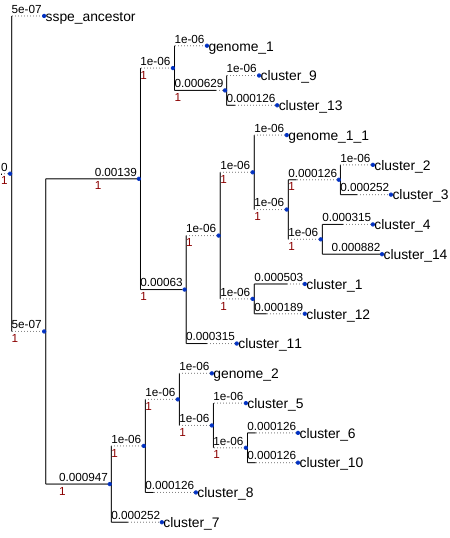

In [10]:
# With midpoint rooting
t = Tree(os.path.join(outpath, "haplotype-sequences.fa.treefile"), format = 1)

t.set_outgroup('sspe_ancestor')

# Tree style
ts = TreeStyle()
ts.show_branch_length = True
ts.show_branch_support = True
ts.show_scale = False


t.render("%%inline", w=5, units="in", tree_style = ts)  